made with Python 3.10.4


Download dataset img_align_celeba.zip from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ
unzip it and put it in the ./img_align_celba/img_align_celeba folder

install all packeges listed in requirements.txt

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, F1Score

creating a new file (data.csv), with better format to read in with a generator, values are separated by coma and each line contains the file name, 1 or 0 for each attribute, 


list_attr_celeba.txt was provided on the website along with the images

In [2]:
#only need to run once, than use data.csv file to load labels
file_path = 'data.csv'

with open("list_attr_celeba.txt") as attr:
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        count = 0
        size = next(attr)
        labels = next(attr).strip()
        firstRow = ["Filenames"] + labels.split()
        writer.writerow(firstRow)
        for line in attr:
            name = line[:11]
            line = line[11:]
            numbers = line.split()
            for (i, number) in enumerate(numbers):
                if number == "-1":
                    numbers[i] = 0
                elif number == "1":
                    numbers[i] = 1
            data = [name] + numbers
            writer.writerow(data)
            

This has to be run every time, it gets the label names and the number off attributes from the labels file

In [3]:
with open("list_attr_celeba.txt") as attr:
        count = 0
        size = next(attr)
        labels = next(attr).strip()
labels = labels.split()

In [4]:
#calculate the split so that we have 80% training, 10% validation, 10% testing
total = int(size)
train_val_split_idx = int(total * 0.8)
val_test_split_idx = int(total * 0.9)
print(total, train_val_split_idx, val_test_split_idx)


202599 162079 182339


We are using generators, to load the data, preprocess it, rescale... and generate more images with horizontal flipping and zooming. The files are loaded from the 

In [6]:
df=pd.read_csv("./data.csv")
columns=labels
horizontal_flip = True
zoom_range = 0.2
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
train_generator=datagen.flow_from_dataframe(
dataframe=df[:train_val_split_idx],
directory="./img_align_celeba/img_align_celeba", #path to images
x_col="Filenames",  #column in csv file that has the filenames
validate_filenames=False, 
y_col=columns, #columns in csv file that has the labels
batch_size=32, 
seed=42, #we are setting the seed, so that we can get the same results each time we run the code, don't have multiple variables
shuffle=True,
class_mode="raw", #we already have the labels in the appropriate format in the file
target_size=(178,218) #all images are already this size, but just in case...
)

valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[train_val_split_idx:val_test_split_idx],
directory="./img_align_celeba/img_align_celeba",
x_col="Filenames",
validate_filenames=False,
y_col=columns,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw", #we already have the labels in the appropriate format
target_size=(178,218))

test_generator=test_datagen.flow_from_dataframe(
dataframe=df[val_test_split_idx:],
directory="./img_align_celeba/img_align_celeba",
x_col="Filenames",
validate_filenames=False,
batch_size=32,
y_col = columns,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(178,218))

Found 162079 non-validated image filenames.
Found 20260 non-validated image filenames.
Found 20260 non-validated image filenames.


In [20]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer = HeNormal() ,input_shape=(178, 218, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer = HeNormal()),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer = HeNormal()),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_initializer = HeNormal()),
    layers.Dense(40, activation='sigmoid')  # There are 40 facial attributes to classify
])



In [21]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(name='accuracy'),Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])




In [150]:
# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 176, 216, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 88, 108, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 86, 106, 64)       18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 43, 53, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 41, 51, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 20, 25, 128)      

In [90]:
#define the steps per epoch for training, validation and testing 
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

If step size is too big, (too long training time, we can decrease it temporarily). 

Number of epochs should be set according to the training length, preferebly it should be "infinity" so that the training is only stopped due to early stopping.

In [24]:
#lower step sizes for quicker training, when testing different models, hyperparameters
STEP_SIZE_TRAIN = 100
STEP_SIZE_VALID = 10

In [153]:
model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1,
    callbacks=[early_stopping]
)

100/100 [==============================] - 116s 1s/step - loss: 0.4976 - accuracy: 0.8195 - precision: 0.6538 - recall: 0.4101 - auc: 0.7946 - val_loss: 0.3763 - val_accuracy: 0.8450 - val_precision: 0.7286 - val_recall: 0.4648 - val_auc: 0.8435


In [154]:
# Save the model (putting timestamp so we can keep track of different models)
t = datetime.now()
current_time = t.strftime("%Y-%m-%d_%H-%M-%S")
model.save(f'./model{current_time}.keras')

In [65]:
#file name needs to be modified to load the model
model = tf.keras.models.load_model('./model.keras')

In [156]:
# Evaluate the model on the test data
test_eval = model.evaluate(test_generator, steps=STEP_SIZE_TEST)

100/100 [==============================] - 34s 337ms/step - loss: 0.3770 - accuracy: 0.8423 - precision: 0.7561 - recall: 0.4781 - auc: 0.8534


In [157]:
print('Test loss      : {}'.format(test_eval[0]))
print('Test accuracy  : {:.3%}'.format(test_eval[1]))
print('Test precision : {:.3%}'.format(test_eval[2]))
print('Test recall    : {:.3%}'.format(test_eval[3]))
print('Test AUC       : {:.3%}'.format(test_eval[4]))

Test loss      : 0.3770066499710083
Test accuracy  : 84.230%
Test precision : 75.612%
Test recall    : 47.811%
Test AUC       : 85.339%


Download pretrained model

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [12]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 9s 0us/step


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

In [14]:
predictions = Dense(40, activation='sigmoid')(x)

In [15]:
modelB = Model(inputs=base_model.input, outputs=predictions)

We freeze all layers in the pretrained model

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
modelB.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy(name='accuracy'),Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

In [91]:
modelB.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1,
    callbacks=[early_stopping]
)

5064/5064 [==============================] - 3803s 751ms/step - loss: 0.2837 - accuracy: 0.8740 - precision: 0.7824 - recall: 0.6116 - auc: 0.9202 - val_loss: 0.2756 - val_accuracy: 0.8785 - val_precision: 0.7838 - val_recall: 0.6245 - val_auc: 0.9243


In [ ]:
# Evaluate the model on the test data
test_evalB = modelB.evaluate(test_generator, steps=STEP_SIZE_TEST)

In [ ]:
print('Test loss      : {}'.format(test_evalB[0]))
print('Test accuracy  : {:.3%}'.format(test_evalB[1]))
print('Test precision : {:.3%}'.format(test_evalB[2]))
print('Test recall    : {:.3%}'.format(test_evalB[3]))
print('Test AUC       : {:.3%}'.format(test_evalB[4]))

Test loss      : 0.3324882686138153
Test accuracy  : 85.229%
Test precision : 73.007%
Test recall    : 57.283%
Test AUC       : 89.132%


In [ ]:
from sklearn import metrics
from sklearn import config_context
import sklearn.pre

In [ ]:
import sklearn
sklearn.set_config(
   assume_finite=True,  # disable validation
)

In [ ]:
y_pred = model.predict(test_generator, steps=STEP_SIZE_TEST+1)
y_true = test_generator.labels

634/634 [==============================] - 96s 152ms/step


In [ ]:
y_pred2 = np.rint(y_pred)
print(y_pred[11])
print(y_pred2[11])
print(y_true[11])

[0.29038954 0.26373476 0.24186873 0.26583833 0.22703147 0.58724797
 0.22629972 0.5141069  0.78428733 0.3435037  0.06311985 0.8507385
 0.4824133  0.44048953 0.4859964  0.68300515 0.35246548 0.5437545
 0.4701694  0.6453462  0.5468899  0.80501854 0.6396574  0.31538785
 0.62627685 0.48670512 0.5949483  0.19124952 0.3586323  0.56213146
 0.38277248 0.21048021 0.5439213  0.4275041  0.40900096 0.4450029
 0.4768628  0.57213455 0.5986237  0.54143286]
[0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 1]


Creating and plotting confusion matrix for all labels separately

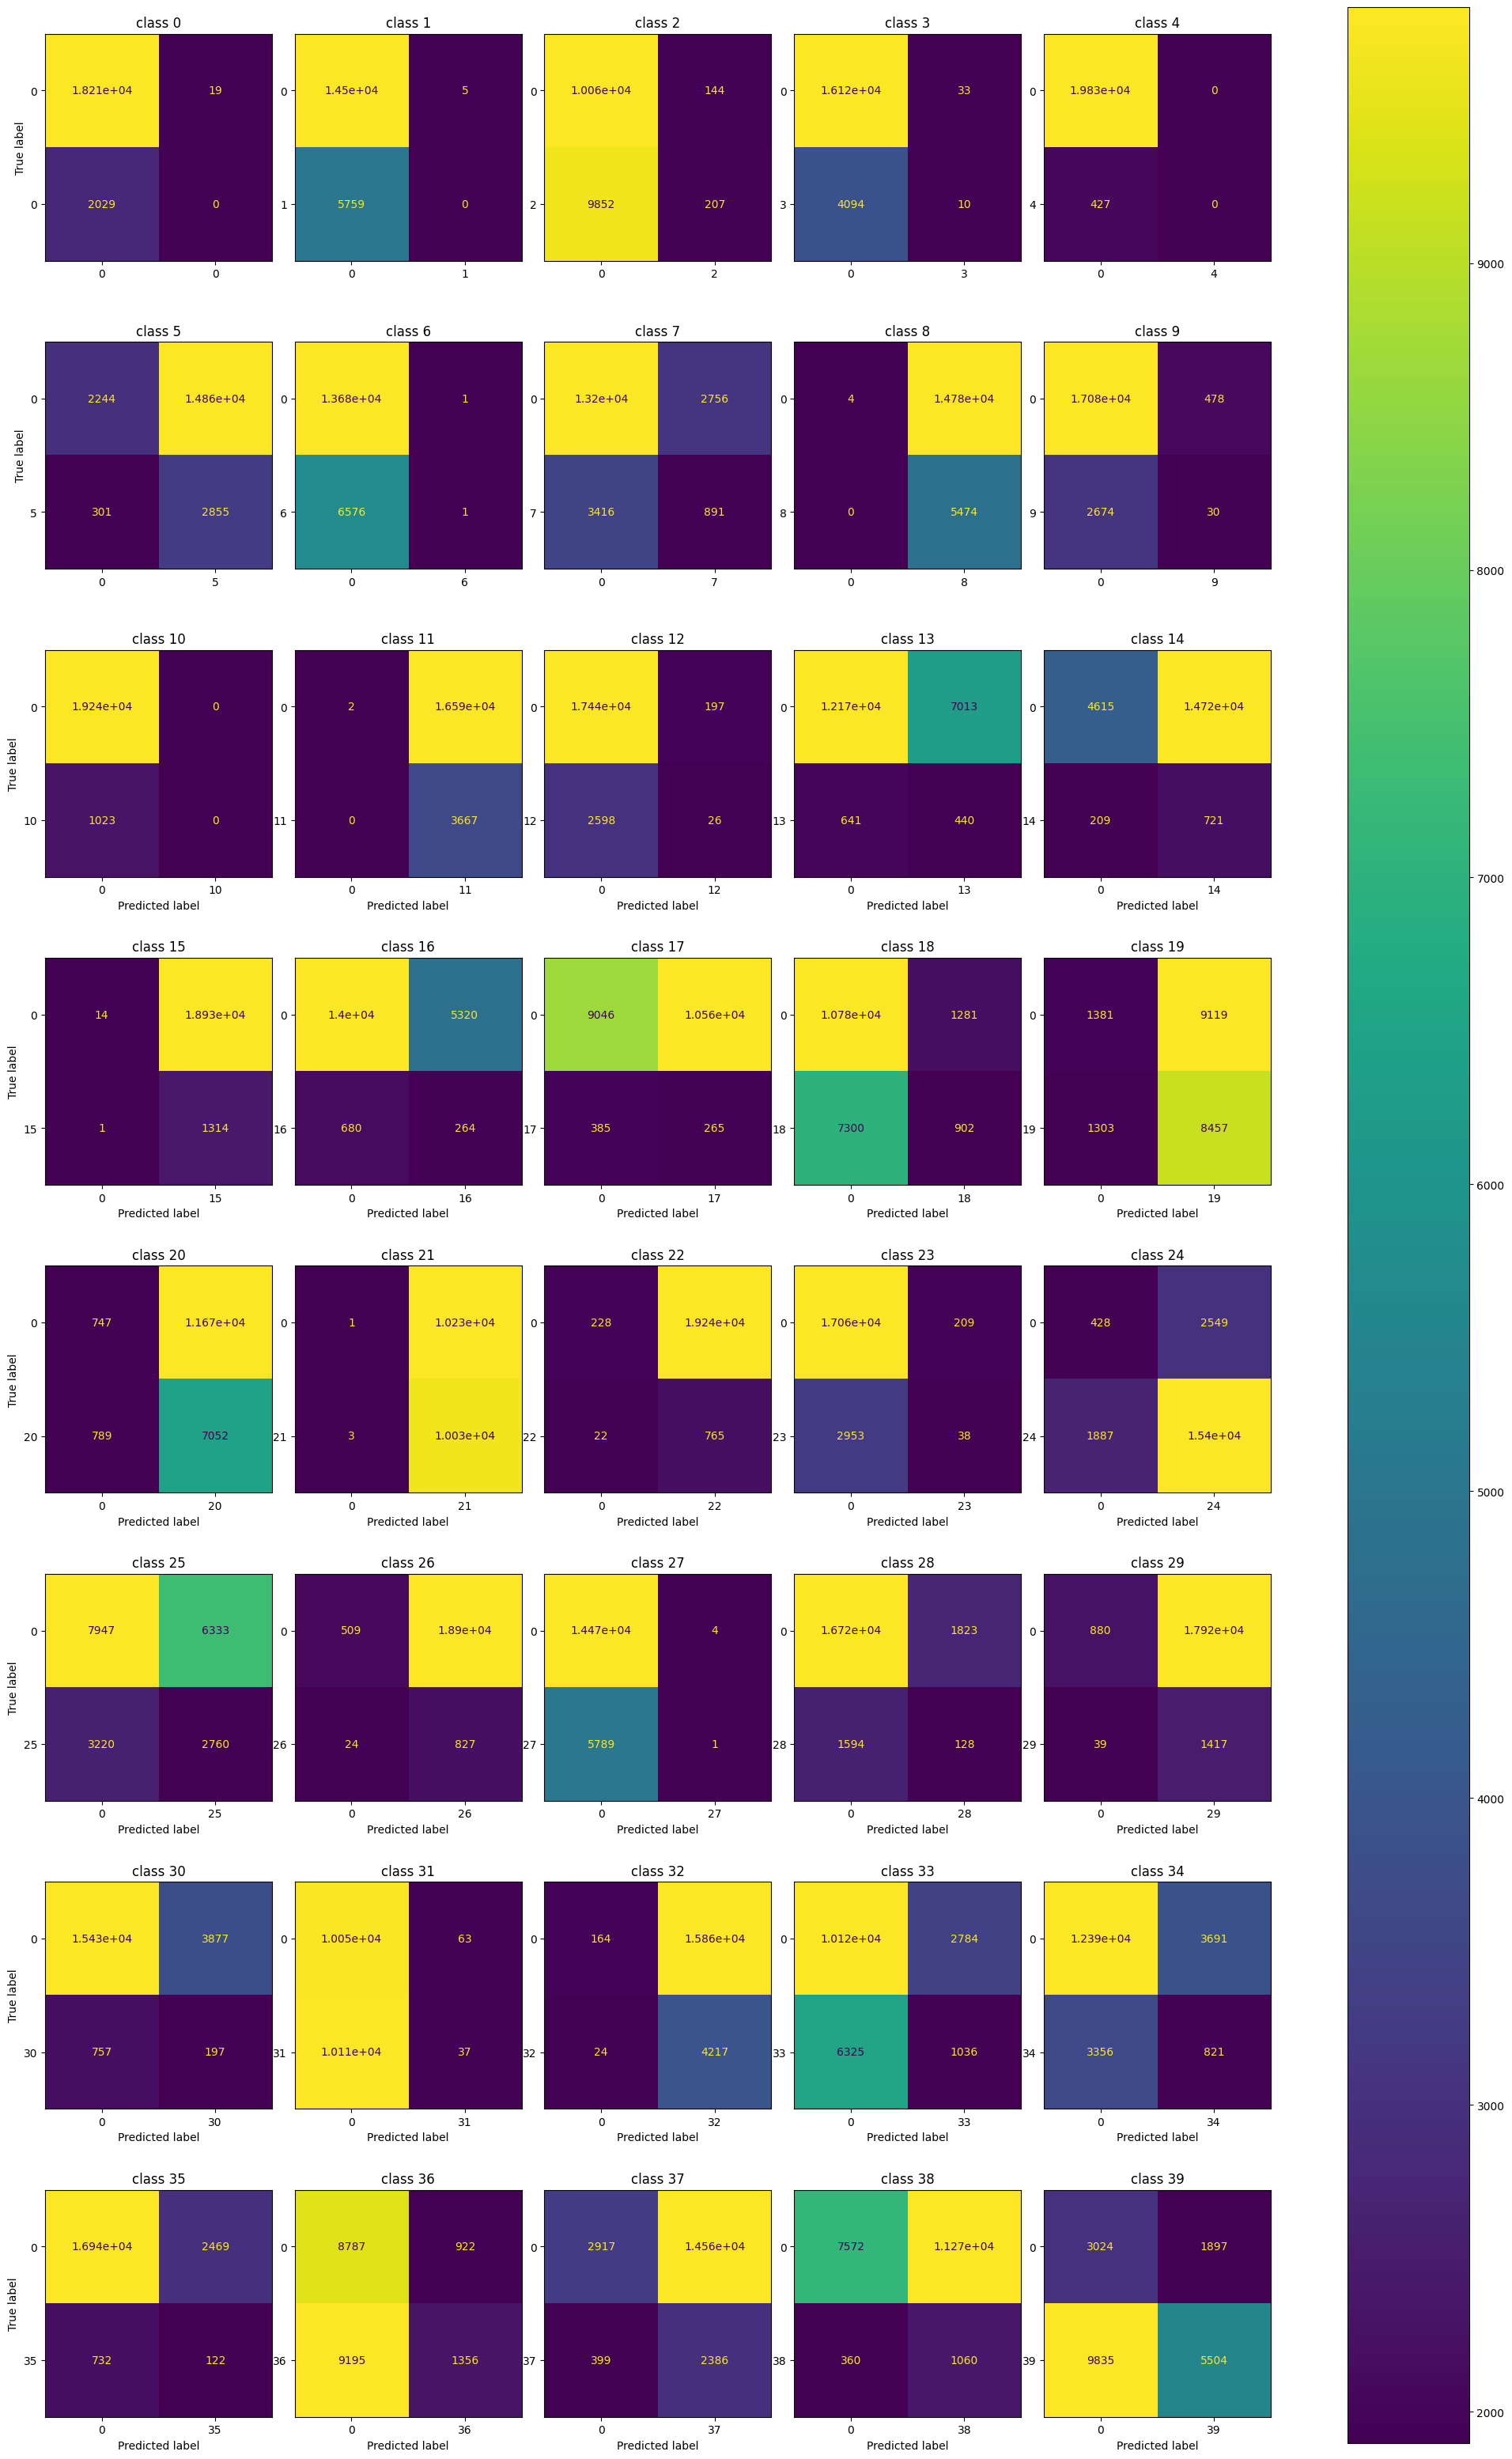

In [ ]:
f, axes = plt.subplots(8, 5, figsize=(25, 40))
axes = axes.ravel()
for i in range(40):
    disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true[:, i],
                                y_pred2[:, i]),
                                display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
# Save the model (putting timestamp so we can keep track of different models)
t = datetime.now()
current_time = t.strftime("%Y-%m-%d_%H-%M-%S")
modelB.save(f'./modelB{current_time}.keras')